In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

# Tạo thư mục kaggle và chép file config vào
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d immulu/bigearthnetv2-s2-0
!unzip bigearthnetv2-s2-0.zip -d ./bigearthnetv2-s2-0

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38_B05.tif  
  inflating: ./bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38_B06.tif  
  inflating: ./bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38_B07.tif  
  inflating: ./bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_86_38_B08.tif  
  inflating: ./bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T11212

In [ ]:
# Sau khi tải về file zip
# !cp bigearthnetv2-s2-0.zip "/content/drive/MyDrive/Document for Capstone"

In [ ]:
!pip install tifffile

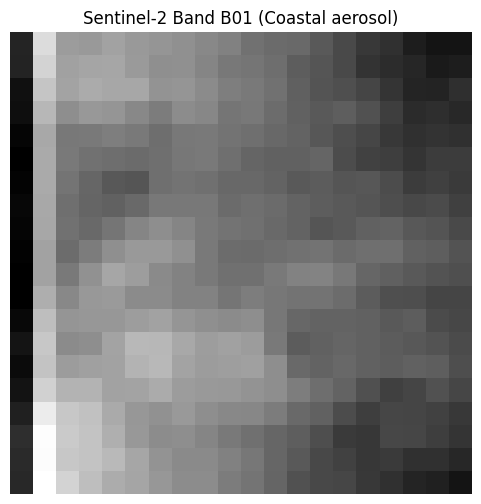

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Đường dẫn ảnh
tif_path = "/content/bigearthnetv2-s2-0/BigEarthNet-S2/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_00_07/S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC_00_07_B01.tif"

# Mở và hiển thị ảnh
with rasterio.open(tif_path) as src:
    band = src.read(1)
    plt.figure(figsize=(6, 6))
    plt.imshow(band, cmap='gray')
    plt.title("Sentinel-2 Band B01 (Coastal aerosol)")
    plt.axis('off')
    plt.show()


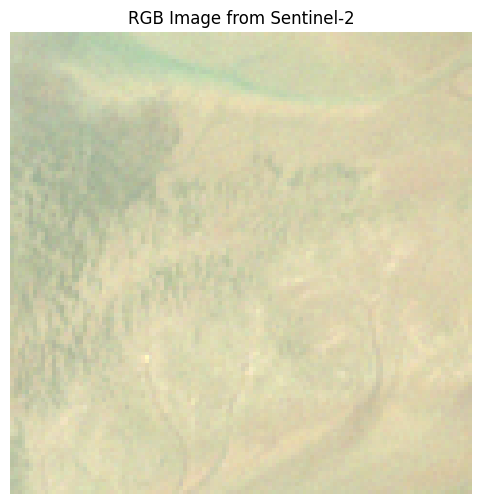

In [ ]:
import numpy as np

# Thay đường dẫn tương ứng với các band
b04_path = tif_path.replace("B01.tif", "B04.tif")
b03_path = tif_path.replace("B01.tif", "B03.tif")
b02_path = tif_path.replace("B01.tif", "B02.tif")

with rasterio.open(b04_path) as r, \
     rasterio.open(b03_path) as g, \
     rasterio.open(b02_path) as b:
    red = r.read(1)
    green = g.read(1)
    blue = b.read(1)

    # Stack lại ảnh RGB và chuẩn hóa
    rgb = np.dstack((red, green, blue)).astype(np.float32)
    rgb /= rgb.max()

    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title("RGB Image from Sentinel-2")
    plt.axis('off')
    plt.show()


In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import numpy as np
from tqdm import tqdm

# Đường dẫn gốc của dataset
root_dir = "/content/bigearthnetv2-s2-0/BigEarthNet-S2"

# Danh sách tên 12 band cần lấy
expected_bands = ["B01", "B02", "B03", "B04", "B05", "B06",
                  "B07", "B08", "B8A", "B09", "B11", "B12"]

# Tạo thư mục output
output_root = "/content/bigearthnet_12band_10m"
os.makedirs(output_root, exist_ok=True)

# Hàm đọc và resize 1 band
def read_and_resample_band(band_path, target_shape, target_transform, target_crs):
    with rasterio.open(band_path) as src:
        if src.shape != target_shape:
            data = src.read(
                out_shape=(1, target_shape[0], target_shape[1]),
                resampling=Resampling.bilinear
            )
        else:
            data = src.read()
        return data[0]

# Duyệt qua toàn bộ thư mục class (0–9)
for class_folder in tqdm(os.listdir(root_dir), desc="Duyệt các class"):
    class_path = os.path.join(root_dir, class_folder)
    if not os.path.isdir(class_path):
        continue

    # Tạo thư mục lưu kết quả theo class
    class_output_path = os.path.join(output_root, class_folder)
    os.makedirs(class_output_path, exist_ok=True)

    # Duyệt từng tile trong class
    for tile_folder in os.listdir(class_path):
        tile_path = os.path.join(class_path, tile_folder)
        if not os.path.isdir(tile_path):
            continue

        band_files = {band: None for band in expected_bands}

        # Lấy đúng 12 band
        for fname in os.listdir(tile_path):
            for band in expected_bands:
                if fname.endswith(f"{band}.tif"):
                    band_files[band] = os.path.join(tile_path, fname)

        # Nếu thiếu band nào → bỏ qua
        if any(v is None for v in band_files.values()):
            print(f"Thiếu band tại {tile_path}")
            continue

        # Mở 1 band 10m (B02) làm tham chiếu resize
        with rasterio.open(band_files["B02"]) as ref:
            ref_shape = ref.shape
            ref_transform = ref.transform
            ref_crs = ref.crs

        bands_stack = []

        try:
            for band in expected_bands:
                band_path = band_files[band]
                band_array = read_and_resample_band(
                    band_path,
                    ref_shape,
                    ref_transform,
                    ref_crs
                )
                bands_stack.append(band_array)

            # Stack thành 12 channel
            multiband_array = np.stack(bands_stack, axis=0)

            # Lưu ảnh
            out_path = os.path.join(class_output_path, tile_folder + "_12band.tif")
            with rasterio.open(
                out_path,
                "w",
                driver="GTiff",
                height=ref_shape[0],
                width=ref_shape[1],
                count=12,
                dtype=multiband_array.dtype,
                crs=ref_crs,
                transform=ref_transform
            ) as dst:
                dst.write(multiband_array)

        except Exception as e:
            print(f"Lỗi tại {tile_path}: {e}")


Duyệt các class: 100%|██████████| 10/10 [22:03<00:00, 132.39s/it]


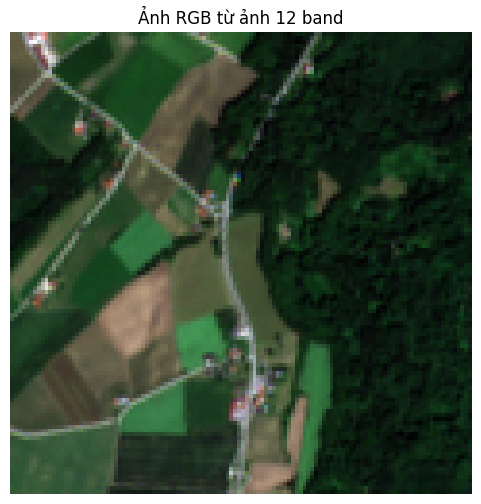

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến 1 ảnh đã xử lý (đảm bảo ảnh này tồn tại)
tif_path = '/content/bigearthnet_12band_10m/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_12band.tif'

def show_rgb_image(tif_path, title=""):
    with rasterio.open(tif_path) as src:
        try:
            r = src.read(4)  # B04
            g = src.read(3)  # B03
            b = src.read(2)  # B02
        except Exception as e:
            print("Lỗi khi đọc band:", e)
            return

        # Normalize để ảnh hiển thị đẹp
        def normalize(channel):
            channel = channel.astype(np.float32)
            return (channel - channel.min()) / (channel.max() - channel.min() + 1e-5)

        rgb = np.stack([normalize(r), normalize(g), normalize(b)], axis=-1)

        plt.figure(figsize=(6, 6))
        plt.imshow(rgb)
        plt.axis('off')
        plt.title(title)
        plt.show()

show_rgb_image(tif_path, title="Ảnh RGB từ ảnh 12 band")


In [ ]:
# Nén thư mục bigearthnet_12band_10m thành file zip
!zip -r /content/bigearthnet_12band_10m.zip /content/bigearthnet_12band_10m

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_41_60_12band.tif (deflated 17%)
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_85_77_12band.tif (deflated 18%)
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_24_70_12band.tif (deflated 16%)
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_78_86_12band.tif (deflated 18%)
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_14_53_12band.tif (deflated 16%)
  adding: content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29S

In [ ]:
# Lưu
!cp /content/bigearthnet_12band_10m.zip "/content/drive/MyDrive/Document for Capstone"